In [ ]:
import os
import scipy.io
from scipy.stats import wilcoxon, friedmanchisquare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from learned_tuning.learned_tuning import calculate_place_field_fidelity_of_learned_tuning, calculate_all_column_correlations

%matplotlib widget


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


normalize_to_max = lambda x:(x/np.nanmax(x))


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

matlab_data_dir = r'/home/kouroshmaboudi/Documents/NCMLproject/assemblyTuning_finalResults/'
# included_session_IDX = [x for x in range(6, 11)]
# included_session_IDX = [x for x in range(5)]
included_session_IDX = [x for x in range(17) if x not in (5,12,13)]
included_session_IDX.append(5)
# included_session_IDX.append(5)
# included_session_IDX = [0]

current_sessions = [sessions[i] for i in included_session_IDX]

number_of_sessions = len(current_sessions)

num_units = np.empty((number_of_sessions,), dtype=int)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object) # to keep track of session identity for each unit when we pool together and sort the units from diferent sessions

# Maze place fields
spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE

# theta amp, phase, frequency, and velocity
theta_features_velocity_binned = np.empty((number_of_sessions,), dtype=object)

# LT fidelities indiv sessions
learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)

theta_features_velocity_names = ['theta_amp', 'theta_freq', 'theta_phase', 'velocity']


# median LT fidelities indiv session
lt_pf_correlation_median = np.empty((number_of_sessions,), dtype=object)
lt_pf_correlation_median_pvalue = np.empty((number_of_sessions,), dtype=object)

gw = gausswindow(3, 9) # for smoothing the tunings 
flag = 1

for session_idx, session_name in enumerate(current_sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]

    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations = epochs[:, 1] - epochs[:, 0]


    #----------------------------------------------------------------------------------------------
    # Load spike data
    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]


    # Load unit stability information

    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]



    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]


    if session_number in [6,7]:
        num_units_total = spatial_tuning_smoothed.shape[0] # for RatN and RatS
    else:
        num_units_total = spatial_tuning_smoothed[0].shape[0]
        
    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}
        
        for direction in running_directions:
            try:
                if session_number in [6,7]:
                    unit_spikes['place_fields_maze'][direction] = spatial_tuning_smoothed[unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]


            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1] 
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]-1
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        else:
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]-1 # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        
        # Extract the cluster quality information by block for the current unit  
        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((len(firing_rate_by_block),))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


        try:
            unit_spikes['pre_post_unit_stability'] = (
                # (unit_spikes['spike_amplitude_by_block'][0][:2] > 0.9) & 
                (unit_spikes['firing_rate_by_block'][0][:2] > 0.33) & 
                (unit_spikes['isolation_distance_by_block'][0][:2] > 15)
            ).all()
        except:
            unit_spikes['pre_post_unit_stability'] = np.nan



        spikes.append(unit_spikes) 


    # place fields by pooling spikes across both running directions
    
    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    pre_post_unit_stability_curr_session = np.empty((num_units_total,))
    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']


        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[session_idx][unit] = spatial_tuning_maze_curr_unit
        pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']



    active_units = np.where((np.nanmax(spatial_tunings_maze[session_idx], axis=1) > 1) & (pre_post_unit_stability_curr_session == True))[0]
    num_units[session_idx] = len(active_units)

    spatial_tunings_maze[session_idx] = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze[session_idx])

    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units]
    spatial_tunings_maze[session_idx][np.isnan(spatial_tunings_maze[session_idx])] = 1e-16



    #---------------------------------------------------------------------------------------------------------
    # Loading maze theta-categorized learned tunings

    learned_tunings_curr_session = dict()

    session_matlab_dataset_path = os.path.join(matlab_data_dir, session_name, 'assemblyTunings')


    # filename = f'{session_name}.assemblyTunings_maze_theta_amp_phase_freq_ripple_channel_above_velocity_10cms-1.mat' #
    filename = f'{session_name}.assemblyTunings_POST_REM_theta_amp_phase_freq_ripple_channel.mat' #

    

    file_path = os.path.join(session_matlab_dataset_path, filename)
    mat_file = scipy.io.loadmat(file_path)

    fields = [key for key in mat_file.keys() if key.startswith('learnedTunings_')]
    theta_features = [string[len('learnedTunings_'):] for string in fields]

    for condition_idx, condition_name in enumerate(fields):
        current_learned_tunings = mat_file[condition_name]

        num_feature_levels = current_learned_tunings.shape[2] # the third dimension
        for level in range(num_feature_levels):
            learned_tunings_curr_session[f"{theta_features[condition_idx]}_{level}"] = current_learned_tunings[:, :, level]


    # Distribution of each theta lfp-feature
    theta_features_velocity_binned[session_idx] = dict()
    for condition_idx, condition_name in enumerate(theta_features_velocity_names[:-1]):
        
        current_key_name = f'{condition_name}_bins'
        current_data = mat_file[current_key_name]
        num_theta_bouts = len(current_data)
        theta_features_velocity_binned[session_idx][condition_name] = []

        for bout_idx in range(num_theta_bouts):
            theta_features_velocity_binned[session_idx][condition_name].append(current_data[bout_idx].item().flatten())

        theta_features_velocity_binned[session_idx][condition_name] = np.concatenate(theta_features_velocity_binned[session_idx][condition_name])



    # #------------------------------------------------------------------------------------------------------------
    # # Loading velocity-categorized learned tunings
    
    # filename = f'{session_name}.assemblyTunings_maze_theta_animal_velocity_min_10cms-1.mat'
    # file_path = os.path.join(session_matlab_dataset_path, filename)
    # mat_file = scipy.io.loadmat(file_path)

    # current_learned_tunings = mat_file['learnedTunings_velocity']
    # num_velocity_levels = current_learned_tunings.shape[2]

    # for level in range(num_velocity_levels):
    #     learned_tunings_curr_session[f'velocity_{level}'] = current_learned_tunings[:, :, level]

    # #Distribution of velcity in theta time bins 
    # current_data = mat_file['velocity_bins']
    # theta_features_velocity_binned[session_idx]['velocity'] = []
    # for bout_idx in range(num_theta_bouts):
    #     theta_features_velocity_binned[session_idx]['velocity'].append(current_data[bout_idx].item().flatten())

    # velocity_temp = np.concatenate(theta_features_velocity_binned[session_idx]['velocity'])
    # # velocity_temp[velocity_temp < 15] = np.nan
    # theta_features_velocity_binned[session_idx]['velocity'] = velocity_temp


    # #-----------------------------------------------------------------------------------------------------------------
    # # Replace all time bins with velocity below 10 cms-1 with nan
    # below_10_vel_index = theta_features_velocity_binned[session_idx]['velocity'] < 10

    # for condition_name in theta_features_velocity_names:
    #     theta_features_velocity_binned[session_idx][condition_name][below_10_vel_index] = np.nan



    if session_idx == 0:
        learned_tuning_conditions = list(learned_tunings_curr_session.keys())


    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()

    lt_pf_correlation_median[session_idx] = dict()
    lt_pf_correlation_median_pvalue[session_idx] = dict()

    num_shuffles = 10000
    for condition_idx, condition_name in enumerate(learned_tuning_conditions):

        learned_tunings[session_idx][condition_name] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):
            curr_unit_learned_tuning = learned_tunings_curr_session[condition_name][active_units[unit]].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')

            # Normalize
            # learned_tunings[session_idx][condition_name][unit] = z_score(curr_unit_learned_tuning)
            learned_tunings[session_idx][condition_name][unit] = normalize_to_max(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        (learned_tunings_place_field_corr[session_idx][condition_name],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][condition_name],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )
        
        # for individual session, calculate the median LT fidelity and test it againt corresponding unit-ID shuffle 
        lt_pf_correlation_median[session_idx][condition_name] = np.nanmedian(learned_tunings_place_field_corr[session_idx][condition_name])
        ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition_name], axis = 0)
        lt_pf_correlation_median_pvalue[session_idx][condition_name] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median[session_idx][condition_name])/num_shuffles

    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)


In [67]:
# Concatenate place fields from all sessions and sort them according to the peak place field locations

spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)
place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

spatial_tunings_maze_sessions_concat = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]

each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_session_number_sessions_concat = each_unit_session_number_sessions_concat[place_fields_sort_idx]


# concatenate the learned tunings 
learned_tunings_sessions_concat = dict.fromkeys(learned_tuning_conditions)
for condition_idx, condition_name in enumerate(learned_tuning_conditions):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][condition_name])
    learned_tunings_sessions_concat[condition_name] = np.concatenate(temp, axis = 0)
    learned_tunings_sessions_concat[condition_name] = learned_tunings_sessions_concat[condition_name][place_fields_sort_idx]


# concatenated the LT fidelities across session, both the actual values and the PF unit id shuffled data, and then calculate the medians and their p-values
learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(learned_tuning_conditions)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(learned_tuning_conditions)
learned_tunings_place_field_corr_p_values_concat = dict.fromkeys(learned_tuning_conditions)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(learned_tuning_conditions)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(learned_tuning_conditions)

for condition_idx, condition_name in enumerate(learned_tuning_conditions):

    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][condition_name])
    learned_tunings_place_field_corr_sessions_concat[condition_name] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition_name])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[condition_name] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]


    # calculate the p-values of place fidelities
    lt_pf_correlation_median_across_all_sessions[condition_name] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[condition_name])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[condition_name], axis = 0)

    lt_pf_correlation_median_across_all_sessions_pvalue[condition_name] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median_across_all_sessions[condition_name])/num_shuffles

# Pool the median PF fidelities and corresponding p-values across sessions
# This will be used later for drawing the lines corresponding to individual sessions, overlaid on the violin plots 
lt_pf_medians = dict.fromkeys(learned_tuning_conditions)
lt_pf_median_p_values = dict.fromkeys(learned_tuning_conditions)

for condition_idx, condition_name in enumerate(learned_tuning_conditions):
    #lt-pf fidelities
    lt_pf_medians[condition_name] = []
    lt_pf_median_p_values[condition_name] = []
    for session_idx in range(number_of_sessions):
        lt_pf_medians[condition_name].append(lt_pf_correlation_median[session_idx][condition_name])
        lt_pf_median_p_values[condition_name].append(lt_pf_correlation_median_pvalue[session_idx][condition_name])

In [68]:
#------------------------------------------------------------------------------------------------------------
# Pooled data of theta lfp features and velocity  

theta_features_velocity_names = ['theta_amp', 'theta_freq', 'theta_phase']


theta_features_velocity_binned_pooled = dict.fromkeys(theta_features_velocity_names)

for condition_idx, condition_name in enumerate(theta_features_velocity_names):
    
    theta_features_velocity_binned_pooled[condition_name] = []

    for session_idx in range(number_of_sessions):
        theta_features_velocity_binned_pooled[condition_name].append(theta_features_velocity_binned[session_idx][condition_name])

    theta_features_velocity_binned_pooled[condition_name] = np.concatenate(theta_features_velocity_binned_pooled[condition_name])


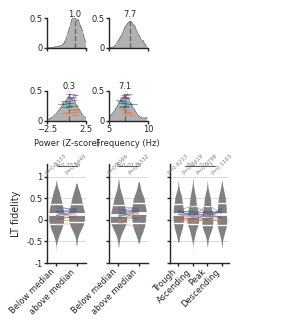

In [81]:
from matplotlib import ticker

#---------------------------------------------------------------------------------------------------------
# Define functions

def  get_x_axis_labels(condition_name, data_to_plot):

    xlabel = ''
    xlim = []
    xticks = []
    xticklabels = []

    if condition_name == 'theta_amp':
        xlabel = 'Power (Z-score)'
        xticks = [-2.5, 2.5]
        xlim = [-2.5, 2.5]

    elif condition_name == 'theta_freq':
        xlabel = 'Frequency (Hz)'
        xlim = [5, 10]
        xticks = [5, 10]

    elif condition_name == 'theta_phase':
        xlabel = 'Radians'
        xticks = [-np.pi, np.pi]
        xticklabels = ['-$\pi$', '$\pi$']

    elif condition_name == 'velocity':
        xlabel = 'cmS^-1'
        # xlim = [0,  np.nanpercentile(data_to_plot, 99.9)]
        xlim = [0, 80]

    return xlabel, xlim, xticks, xticklabels


def remove_trailing_zeros(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)




def plot_violin(ax, data, color):
    alpha = 1
    sns.violinplot(data=list(data.values()), ax=ax, color=color, inner='quartiles', linewidth=0, cut=0)
    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 2):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(1)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(2)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement

# def get_pval_statement(pvalue, sign):
#     if pvalue < 0.0001:
#         pvalue_statement = sign*2    
#     elif pvalue < 0.01:
#         pvalue_statement = sign
#     else:
#         pvalue_statement = 'ns'
#     return pvalue_statement

#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':1,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})


#-------------------------------------------------------------------------------------------------------------
# Generate the figure

# Create figure and subplots
plotheight = 3.25
plotwidth = 3
font_size = 6

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 
def get_epoch_color(i):
    if i<= 2:
        color = colors[0]    
    elif i <=4:
        color = colors[1]
    else:
        color = colors[2]
    return color


dataset_specific_colors = ["#E58044", "#046C7C", "#85459B"] # , 


fig = plt.figure()
fig.set_size_inches([plotwidth, plotheight])
gs = GridSpec(nrows=3, ncols=4, figure=fig, height_ratios=[0.3, 0.3, 1], width_ratios = [0.5, 0.5, 0.75, 0.5]) #, height_ratios=[1, 1]

# Comapring the learned tunings calculated for each theta lfp feature (amp, phase, freq) and velocity at different levels 
for condition_idx, condition_name in enumerate(theta_features_velocity_names):
    

    if condition_name != 'theta_phase':

        # plot the distribution of each theta feature/ velocity for an example dataset
        session_idx_to_plot = 0

        ax0 = fig.add_subplot(gs[0, condition_idx])
        current_values = theta_features_velocity_binned[session_idx_to_plot][condition_name]
        sns.histplot(current_values, bins=30, cumulative=False, stat='density', kde=True, color=(.4,.4,.4), edgecolor='none', line_kws={'linewidth':0.5}, ax = ax0)
        ax0.set_ylabel("")
        # ax0.set_title(f'{condition_name}', color='black', y = 1, fontsize = 7)

        ax0.axvline(x=np.nanmedian(current_values), color=(.4,.4,.4), linestyle = '--', linewidth=1)
        ax0.set_ylim([0, 0.5])
        ax0.set_yticks([0, 0.5], [0, 0.5])
        yl = ax0.get_ylim()
        ax0.text(np.nanmedian(current_values), 1.05*yl[1], f'{np.nanmedian(current_values):.1f}', ha='center', fontsize=6)
        ax0.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))

        xlabel, xlim, xticks, xticklabels = get_x_axis_labels(condition_name, current_values)
        
        if len(xlim) > 0: ax0.set_xlim(xlim)
        if len(xticks) > 0: ax0.set_xticks(xticks)
        ax0.set_xticklabels('')

        ax0.tick_params(axis='both', which='major', labelsize=6, length=2, width = 1, pad=1)


        # plot the same but for the data pooled across sessions
        ax1 = fig.add_subplot(gs[1, condition_idx])
        current_values = theta_features_velocity_binned_pooled[condition_name]
        sns.histplot(current_values, bins=30, cumulative=False, stat='density', kde=True, color=(.4,.4,.4), edgecolor='none', line_kws={'linewidth':0.5}, ax = ax1)
        ax1.set_ylabel("")

        
        ax1.set_ylim([0, 0.5])
        ax1.set_yticks([0, 0.5], [0, 0.5])
        ylim_old = ax1.get_ylim()
        ax1.set_ylim([0, ylim_old[1]])
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))

        if condition_name != 'theta_phase':
            ax1.axvline(x=np.nanmedian(current_values), color=(.4,.4,.4), linestyle = '--', linewidth=1)
            yl = ax1.get_ylim()
            ax1.text(np.nanmedian(current_values), 1.05*yl[1], f'{np.nanmedian(current_values):.1f}', ha='center', fontsize=6)


        ylim = ax1.get_ylim()
        for session_idx in range(number_of_sessions):
            session_number = included_session_IDX[session_idx]
            if session_number in range(5):
                color = dataset_specific_colors[0]
            elif session_number in range(6,11):
                color = dataset_specific_colors[1]
            else:
                color = dataset_specific_colors[2]

            current_session_data = theta_features_velocity_binned[session_idx][condition_name]

            # ax1.scatter(np.nanmedian(current_session_data), 0.6*ylim[1]+ np.random.normal(0, 0.2*ylim[1], 1), s= 0.5, color=color, alpha=0.8) 
            
            current_session_y = 0.2*ylim[1]+0.05*session_idx*ylim[1]
            ax1.plot([np.nanpercentile(current_session_data, 25), np.nanpercentile(current_session_data, 75)], [current_session_y]*2, linewidth=0.5, color=color, alpha=0.8)
            ax1.scatter(np.nanmedian(current_session_data),  current_session_y, s= 0.25, color=color, alpha=0.8) 


        xlabel, xlim, xticks, xticklabels = get_x_axis_labels(condition_name, current_values)
        if len(xlim) > 0: ax1.set_xlim(xlim)
        if len(xticks) > 0: ax1.set_xticks(xticks)
        if len(xlabel) > 0: ax1.set_xlabel(xlabel)

        ax1.tick_params(axis='both', which='major', labelsize=6, length=2, width = 1, pad=1)



    # plot the lt-pf fidelities
    ax1 = fig.add_subplot(gs[2, condition_idx])

    current_pf_correlation_values = {k:v for k, v in learned_tunings_place_field_corr_sessions_concat.items() if k.startswith(condition_name)}
    current_pf_median_pvalues = {k:v for k, v in lt_pf_correlation_median_across_all_sessions_pvalue.items() if k.startswith(condition_name)}

    current_lt_pf_medians_indiv = [v for k, v in lt_pf_medians.items() if k.startswith(condition_name)]
    current_lt_pf_medians_indiv = np.array(current_lt_pf_medians_indiv)
    current_lt_pf_medians_indiv = np.transpose(current_lt_pf_medians_indiv)

    plot_violin(ax1, current_pf_correlation_values, (.5, .5, .5))
    # [ax1.plot(indiv_session, linewidth= 0.5, color=(.3,.3,.3, 0.7)) for indiv_session in current_lt_pf_medians_indiv]
    for session_idx in range(number_of_sessions):
        session_number = included_session_IDX[session_idx]
        if session_number in range(5):
            color = dataset_specific_colors[0]
        elif session_number in range(6,11):
            color = dataset_specific_colors[1]
        else:
            color = dataset_specific_colors[2]

        ax1.plot(current_lt_pf_medians_indiv[session_idx], linewidth= 0.5, color=color, alpha=0.6) 


    if condition_name == 'theta_phase':
        ax1.set_xticklabels(['Trough', 'Ascending', 'Peak', 'Descending'], rotation=45, ha='right')
    else:
        ax1.set_xticklabels(['Below median', 'above median'], rotation=45, ha='right')

    ax1.set_xlabel("")
    ax1.set_ylim([-1,1.3])
    ax1.set_yticks(np.arange(-1, 1.1, 0.5))

    ax1.tick_params(axis='both', which='major', labelsize=6, length=2, width = 1, pad=1)
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))

    if condition_idx > 0:
        ax1.set_yticklabels("")


    if condition_idx == 0:
        ax1.set_ylabel('LT fidelity', fontsize = 7)
    # ax1.set_title(f'{condition_name}', color='black', y = 1, fontsize = 7)


    # Add p-values for each violin
    for i, (condition, data) in enumerate(current_pf_correlation_values.items()):
        p_val = current_pf_median_pvalues[condition]
        ax1.text(i, .8*ax1.get_ylim()[1], get_pval_statement(p_val), ha='center', fontsize=4, rotation=45, color='gray')    

    # wlicoxon sign rank test or friedman chi square test between low and high levels
    data_array = np.array([current_pf_correlation_values[key] for key in current_pf_correlation_values.keys()])
    data_array = np.transpose(data_array)
    num_columns = data_array.shape[1]

    if data_array.shape[1] == 2: # signed-rank test
        _, p_value = wilcoxon(data_array[:, 0], data_array[:, 1], nan_policy='omit')
    else: # Friedman test
        not_nan_idx = np.where(~np.isnan(data_array).any(axis=1))[0]
        data_array_cln = data_array[not_nan_idx]
        _, p_value = friedmanchisquare(data_array_cln[:,0], data_array_cln[:,1], data_array_cln[:,2], data_array_cln[:,3])

        post_hoc_p_value = np.full((num_columns, num_columns), np.nan)
        medians = np.nanmedian(data_array, axis=0)
        # post-hoc signed-rank tests
        for i in range(num_columns):
            for j in range(i+1, num_columns):
                _, post_hoc_p_value[i, j] = wilcoxon(data_array[:, i], data_array[:, j], nan_policy='omit')


    ax1.axhline(y=0.95*ax1.get_ylim()[1], xmin = 0.25, xmax = 0.75, color = 'black', linewidth=0.5)
    ax1.annotate(get_pval_statement(p_value), xy = (np.mean(ax1.get_xlim()), ax1.get_ylim()[1]), xytext = (np.mean(ax1.get_xlim()), 1.2), color = 'gray', ha = "center", va="bottom", fontsize = 4)


plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

# fig.suptitle('pooled_theta_amp_phase_velocity_learned_tunings', y=1)

plt.show()

# filename = 'learned_tunings_maze_theta_lfp_feature_velocity_pooled.pdf'
filename = 'learned_tunings_REM_theta_lfp_feature_velocity_pooled.pdf'

file_path = os.path.join(data_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


In [80]:
_, p_value = friedmanchisquare(data_array_cln[:,0], data_array_cln[:,1], data_array_cln[:,2], data_array_cln[:,3])
print(p_value)

0.0015244200272127389


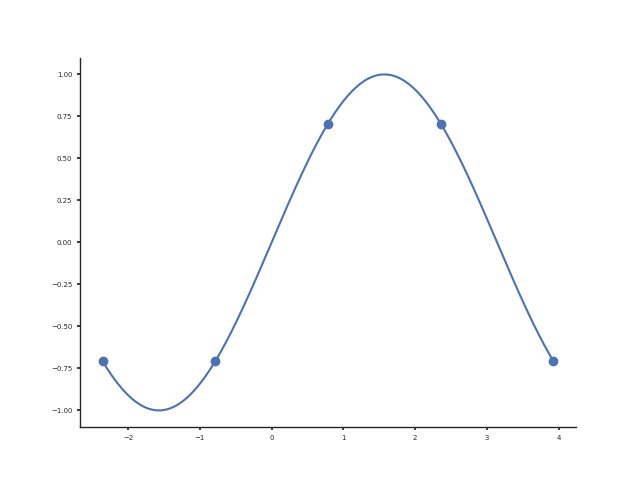

In [65]:
import numpy as np
import matplotlib.pyplot as plt

amplitude = 1
angular_frequency = 1


phase_start = -np.pi/4 - np.pi/2
phase_end = 7*np.pi/4 - np.pi/2

time = np.linspace(phase_start, phase_end, 1000)


sin_wave = amplitude * np.sin(angular_frequency * time)

plt.figure()
plt.plot(time, sin_wave, label='Sine Wave')

range_indicators = np.arange(phase_start, phase_end+0.01, np.pi/2)
plt.scatter(range_indicators, amplitude * np.sin(angular_frequency * range_indicators))

plt.show()

filename = 'sine_wave.pdf'
file_path = os.path.join(data_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


In [59]:
phase_start

-2.356194490192345